# Cell deconvolution comparison and quality control
**Performed by Louise Huuki**

In [1]:
library(tidyverse)
library(ggpubr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Functions

In [2]:
get_pheno <- function(){
    df = data.table::fread("../../../input/phenotypes/merged/_m/merged_phenotypes.csv") %>%
        filter(Dx %in% c("Control"), Age > 17, Race %in% c("AA", "CAUC")) %>%
        mutate(Race = gsub("CAUC", "EA", Race)) %>% select(-V1)
    return(df)
}

memPHENO <- memoise::memoise(get_pheno)

save_img <- function(image, fn, w, h){
    for(ext in c(".svg", ".pdf", ".png")){
        ggsave(file=paste0(fn, ext), plot=image, width=w, height=h)
    }
}

## Prepare data

In [3]:
load("../../_m/est_prop_Bisque.v2.Rdata", verbose = TRUE)
names(est_prop_bisque)

Loading objects:
  est_prop_bisque


[1] "dg"      "caudate" "hippo"   "dlpfc"

In [4]:
cc = est_prop_bisque$caudate$Est.prop.long %>% 
    inner_join(memPHENO(), by=c("sample"="RNum")) %>%
    mutate_if(is.character, as.factor) %>%
    rename("Proportion"="prop") %>% mutate(Tissue="Caudate")
dd = est_prop_bisque$dlpfc$Est.prop.long %>% 
    inner_join(memPHENO(), by=c("sample"="RNum")) %>%
    mutate_if(is.character, as.factor) %>%
    rename("Proportion"="prop") %>% mutate(Tissue="DLPFC")
hh = est_prop_bisque$hippo$Est.prop.long %>% 
    inner_join(memPHENO(), by=c("sample"="RNum")) %>%
    mutate_if(is.character, as.factor) %>%
    rename("Proportion"="prop") %>% mutate(Tissue="Hippocampus")
gg = est_prop_bisque$dg$Est.prop.long %>% 
    separate(sample, c("sample", "batch")) %>% 
    inner_join(memPHENO(), by=c("sample"="RNum")) %>%
    mutate_if(is.character, as.factor) %>%
    rename("Proportion"="prop") %>% mutate(Tissue="Dentate Gyrus")

df = bind_rows(cc, dd, hh, gg)
df %>% head(2)

,sample,cell_type,Proportion,BrNum,Region,RIN,Age,Sex,Race,Dx,mitoRate,rRNA_rate,overallMapRate,Tissue,batch
,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
1,R12872,Astro,0.05615308,Br949,Caudate,9.2,18.05,M,AA,Control,0.02136239,2.860405e-05,0.9097448,Caudate,NA
2,R12873,Astro,0.05615373,Br991,Caudate,9.4,35.24,M,AA,Control,0.02258917,2.795915e-05,0.8991615,Caudate,NA


## Cell type proportion plots

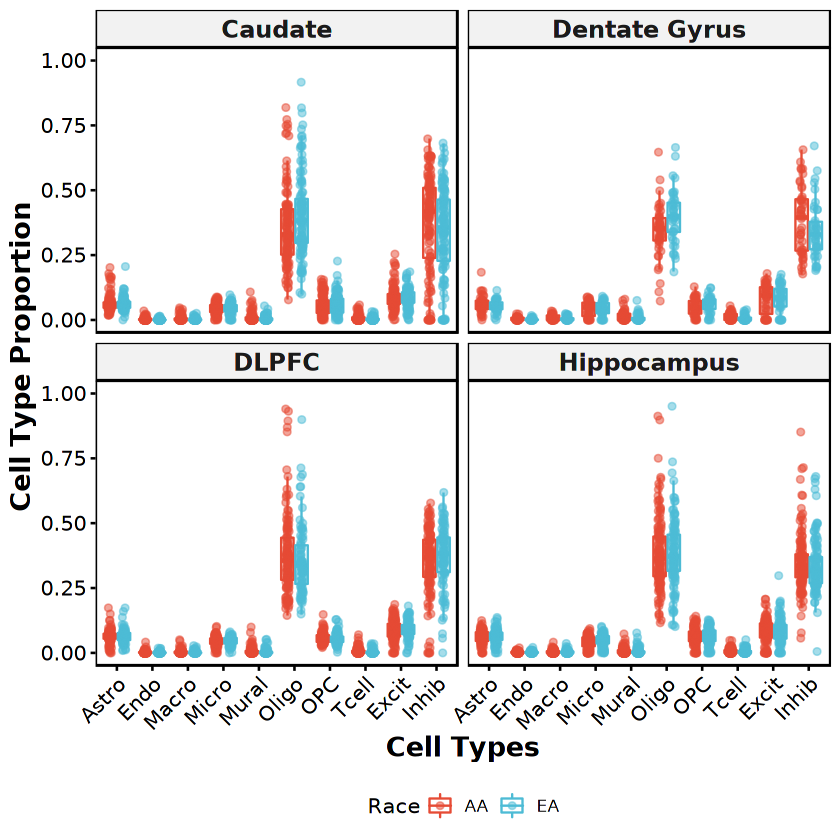

In [5]:
bxp = df %>% ggboxplot(x="cell_type", y="Proportion", color="Race", facet.by="Tissue",
                 panel.labs.font=list(face='bold', size = 14), palette="npg", 
                 outlier.shape=NA, ylab='Cell Type Proportion', add='jitter', 
                 add.params=list(alpha=0.5), ylim=c(0, 1), xlab="Cell Types", 
                       legend="bottom") +
    font("xy.text", size=12) + font("xy.title", size=16, face="bold") + 
    rotate_x_text(45)
print(bxp)
save_img(bxp, paste0("boxplot_celltypes_ancestry"), w=7, h=6)

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


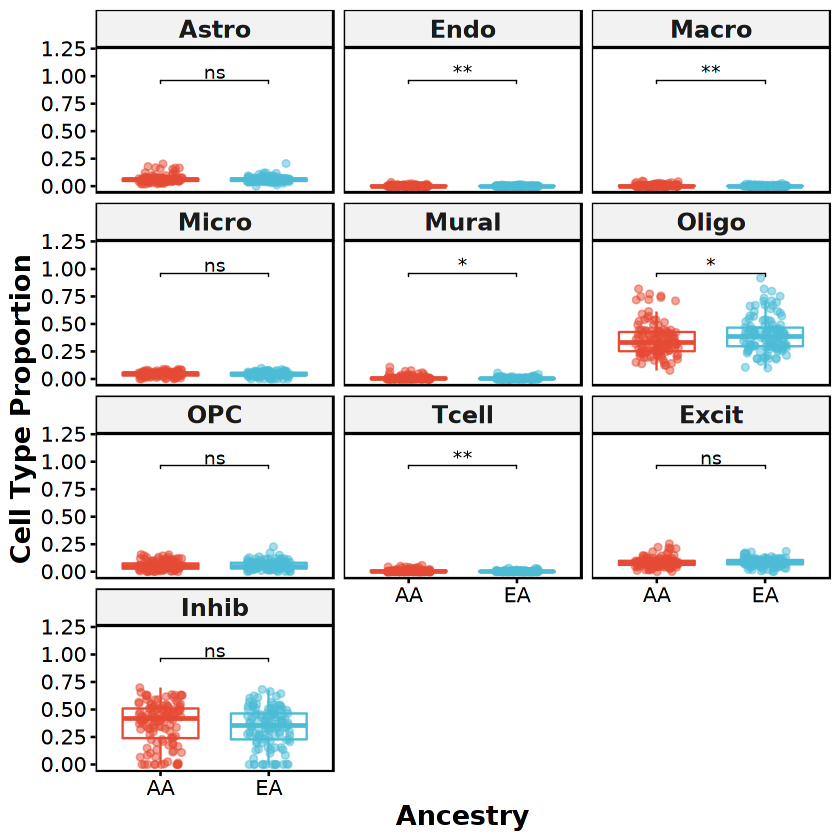

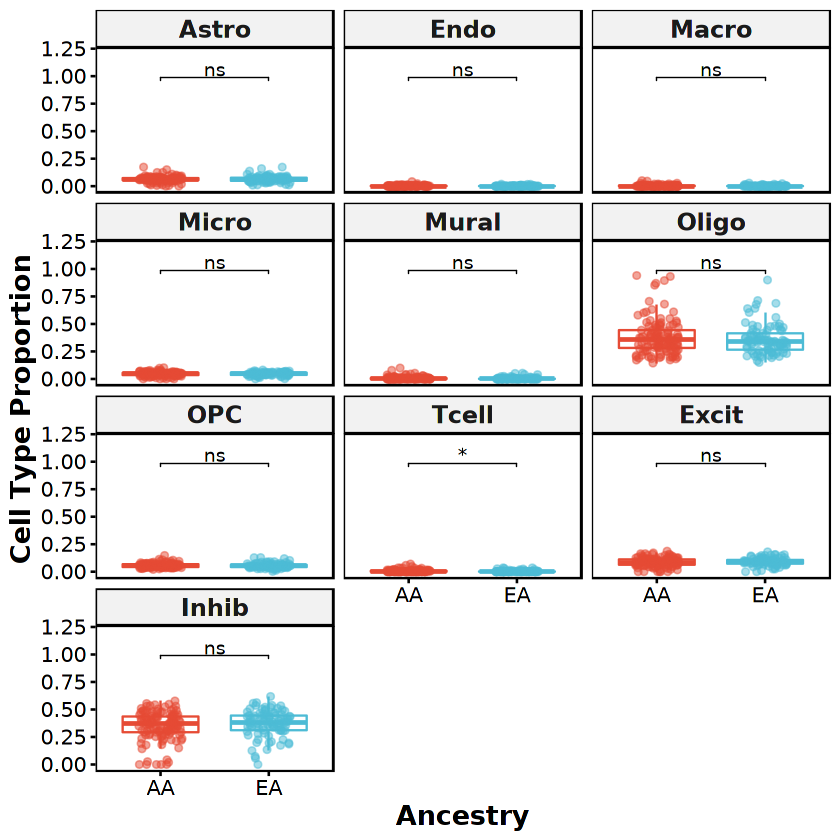

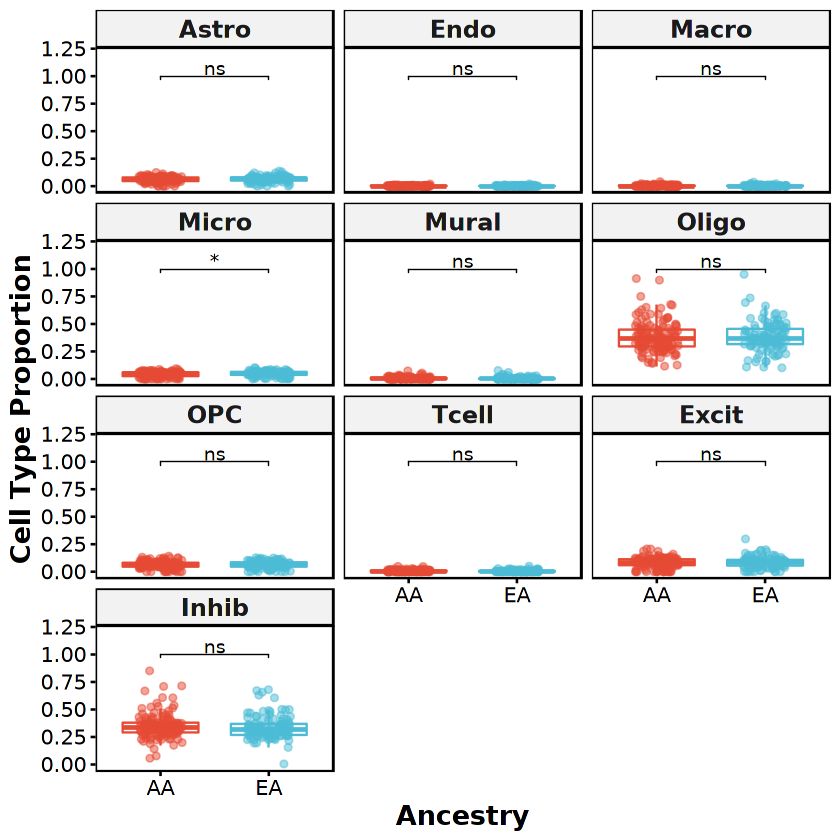

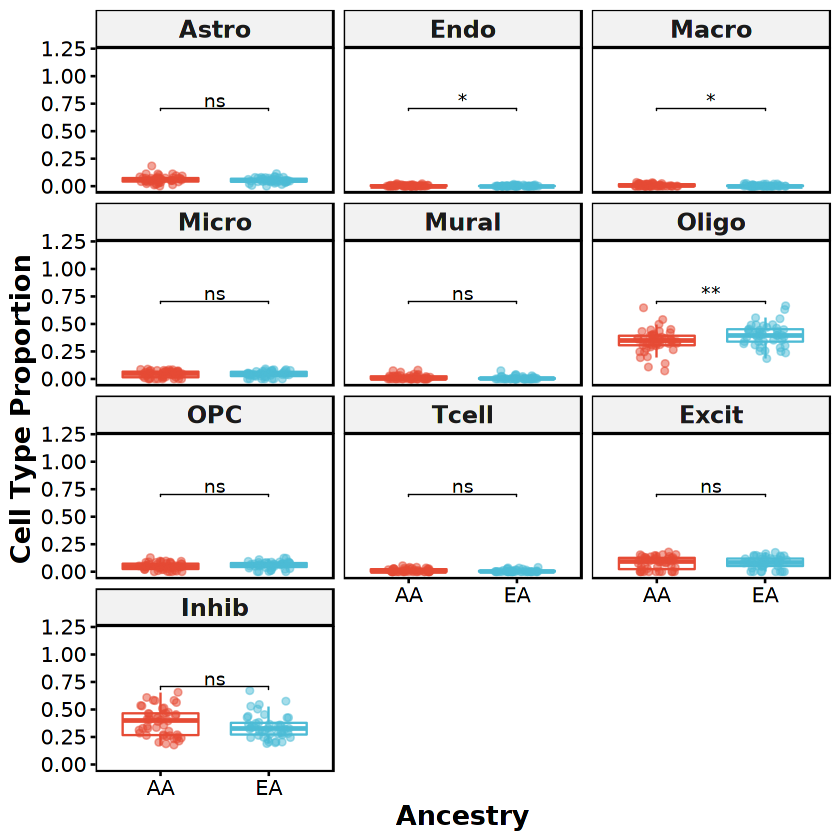

In [6]:
for(tissue in c("Caudate", "DLPFC", "Hippocampus", "Dentate Gyrus")){
    bxp = df %>% filter(Tissue == tissue) %>%
        ggboxplot(x="Race", y="Proportion", color="Race", facet.by="cell_type",
                  panel.labs.font=list(face='bold', size = 14), palette="npg", 
                  outlier.shape=NA, ylab='Cell Type Proportion', add='jitter', 
                  add.params=list(alpha=0.5), ylim=c(0, 1.2), ncol=3, 
                  xlab="Ancestry", legend="None") +
        stat_compare_means(comparisons=list(c("AA", "EA")), aes(label=..p.signif..), 
                           method="t.test") +
        font("xy.text", size=12) + font("xy.title", size=16, face="bold")
    print(bxp)
    fn = paste0("boxplot_ancestryBYcelltype_",gsub(" ", "_", tolower(tissue)))
    save_img(bxp, fn, w=7, h=6)
}

## Reproducibility Information

In [7]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2021-08-25 14:56:34 EDT"

   user  system elapsed 
 28.506   0.677  28.290 

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.3 (2020-10-10)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       America/New_York            
 date     2021-08-25                  

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package     * version  date       lib source        
 abind         1.4-5    2016-07-21 [1] CRAN (R 4.0.2)
 assertthat    0.2.1    2019-03-21 [1] CRAN (R 4.0.2)
 backports     1.2.1    2020-12-09 [1] CRAN (R 4.0.2)
 base64enc     0.1-3    2015-07-28 [1] CRAN (R 4.0.2)
 broom         0.7.8    2021-06-24 [1] CRAN (R 4.0.3)
 cachem        1.0.5    2021-05-15 [1] CRAN (R 